In [2]:
import cv2

import matplotlib.pyplot as plt
import numpy as np

from scipy import signal

In [3]:
# Point to file source of mp4
VIDEO_LOCATION = "media/office_dance_vid.mp4"

In [4]:
capture = cv2.VideoCapture(VIDEO_LOCATION)
success, previous_frame = capture.read()
if not success:
    raise FileNotFoundError("Video file not found")
previous_frame_greyscale = cv2.cvtColor(previous_frame, cv2.COLOR_BGR2GRAY)
# hsv = np.zeros_like(frame1)
# hsv[...,1] = 255
optical_flow = list()

In [5]:
frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))

In [6]:
for _ in range(frame_count - 1):
    _, current_frame = capture.read()
    current_frame_grayscale = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(
        previous_frame_greyscale, 
        current_frame_grayscale, 
        None, 
        0.5, 
        3, 
        15, 
        3, 
        5, 
        1.2, 
        0
    )
    optical_flow.append(flow)
    previous_frame_greyscale = current_frame_grayscale

In [7]:
np_optical_flow = np.array(optical_flow)

In [20]:
x = np_optical_flow[:1].ravel()

In [22]:
x.shape

(1036800,)

In [23]:
frequencies, times, spectrogram = signal.spectrogram(x)

<ipython-input-24-f74019a51f63>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(times, frequencies, spectrogram)


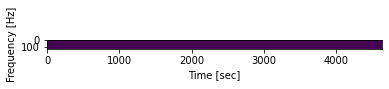

In [24]:
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()